# Paper reproduction: Communication-Efficient Distributed SGD using Preamble-based Random Access by Choi Available at https://arxiv.org/abs/2105.09427

## Imports and Definitions

In [303]:
# Import needed libraries
import numpy as np
import matplotlib.pyplot as plt

In [304]:
# Definitions
K = 100 # Number of datasets distributed over K devices (i.e., 1 data set per device)
L = 10 # Lenght of w
u =  0.01 # step size or learning rate
T = 5000 # Number of iterations

## Auxiliary functions

Construct the codebook as a scaled cross polytope:
$$ \cal{C}_{cp} = \{ \pm \textrm{R}e_l : \{1,...,\textrm{L}\}\} $$
with $ R = \sqrt{L} $.

In [305]:
def construct_codebook(L):
    # Construct the codebook as a scaled cross polytope
    R = np.sqrt(L)
    codebook = np.concatenate(((np.eye(L)*R),(np.eye(L)*(-R))),axis=0)
    return codebook

## Class Device

In [306]:
class Device:
    def __init__(self,L, weights_optimal,codebook):
        
        self.weights = np.zeros(L) # Initialize device's weights to 0
        self.x = np.random.normal(size = (1,L)) # Initialize devices's data set
        self.y = self.x@weights_optimal # Initalize y used for the gradient
        self.g = np.zeros(L)
        self.codebook = codebook
        
    def setWeights(self,new_weights):
        self.weights = new_weights
        
    def gradient(self):
    
        # Calculating the Gradient:
        # 1. Compute predictions, given the feature matrix X of shape (m,n) and weight vector w of shape (n,1).
        #    Predictions should be stored in an array `y_hat` of shape (m,1).
        y_hat = self.x@self.weights
        # 2. compute MSE loss
        m = x.shape[0]
        MSE = (1/m)*np.sum((self.y-y_hat)**2)
        # 3. compute average gradient of loss function
        gradient = (-2/m)*self.x.T@(self.y-y_hat)

        self.g = gradient
        return gradient, MSE
    
    def quantize_weights(self):
        
        quantized_weights = 0
        
        return quantized_weights
    
    def select_codeword(self):
        
        M = self.codebook.shape[0]
        m = np.random.randint(M)
        codeword = codebook[m] 
        
        return m, codeword

## Class Base Station

In [307]:
class BaseStation:
    def __init__(self,L,codebook):
        
        self.weights = np.zeros(L)
        self.codebook = codebook
        
    def setWeights(self,new_weights):
        self.weights = new_weights
        
        
    def gradient_step(self,gradients,step_size):
        
        k = gradients.shape[0]
        avg_gradients = 1/k*np.sum(gradients, axis=0)
        
        self.weights = self.weights - step_size*avg_gradients
        
        return self.weights
        

## Training

In [313]:
w_optimal = np.random.normal(size = L) # initialize w*

devices = [Device(L,w_optimal,codebook) for k in range(K)] # create list with K devices

base_station = BaseStation(L,codebook) # create Base Station

codebook = construct_codebook(L) # Create codebook

In [316]:
%%time
mse = np.zeros(T)

for t in range(T):
    gradients = []
    codewords = []
    g_est = 0
    for d in devices:
        g,mse_d = d.gradient()
        mse[t] += (1/K)*mse_d
        gradients.append(g)
        m, cw = d.select_codeword()
        codewords.append(cw)
        v_norm = np.linalg.norm(g)
        g_est += (1/K)*v_norm*cw
        # v_max = np.linalg.norm(g,np.inf) # Maximum Norm
        # p_k = v_norm/v_max
        # print(v_norm, v_max,p_k)
        # input()
    gradients = np.array(gradients)

    avg_gradients = (1/K)*np.sum(gradients, axis=0)
    
    # print(avg_gradients, g_est)
    # input()
    weight_update = base_station.gradient_step(gradients,u)
    
    for d in devices:
        d.setWeights(weight_update)


Wall time: 13.4 s


## Ploting

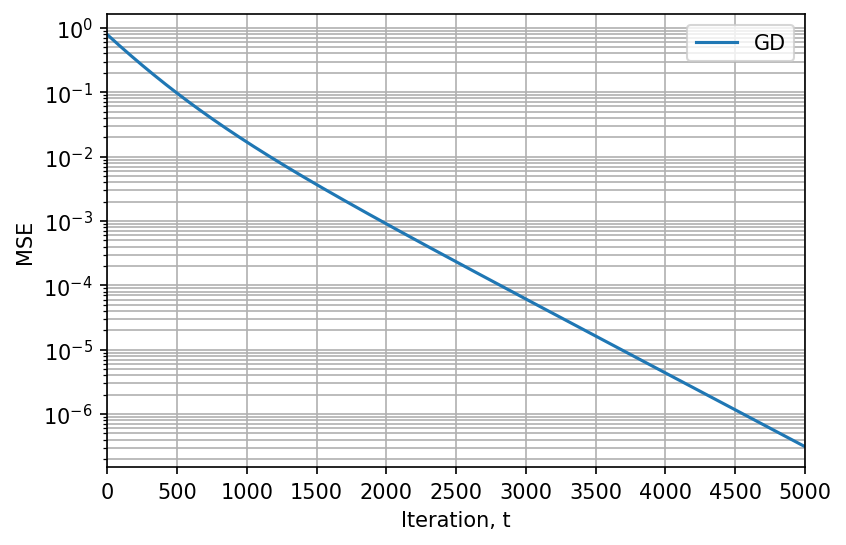

In [317]:
plt.figure(1, dpi = 150)
plt.xticks(np.linspace(0, T, 11))
# plt.ylim(10**-12, 10**2)
plt.xlim(0, T)
plt.grid(True, which = 'both', ls='-')
plt.semilogy(range(T), mse, label = 'GD')

plt.xlabel('Iteration, t')
plt.ylabel('MSE')
plt.legend()

plt.show()